# Agrupando moléculas com o algoritmo Butina

- Carga dos dados e cálculo de fingerprints

In [1]:
!pip install rdkit pyspark findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=5eae66cbfbaabed204085a3f5e7045f79d8e847d96cea1aa699e86ba1e1b1c52
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [2]:
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import findspark
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from pyspark import SparkContext, SparkConf

findspark.init()
# random.seed(2023)

In [3]:
conf = SparkConf().setAppName("Matrix Calculation").setMaster("local[*]")
sc = SparkContext.getOrCreate(conf=conf)

digits = 16
rows = 5000
num_partitions = 4

# criar RDD a partir dos dados
data_rdd = sc.parallelize(np.random.randint(0, 2, size=(digits, rows)), num_partitions)

# executar operação em paralelo para criar array numpy
data = np.array(data_rdd.collect())

data

array([[1, 0, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

# Calculando a matriz de similaridade e distância de Tanimoto</b></font><br>

-  Com as fingerprints, passamos para a identificação dos potenciais centroides do cluster, definindo funções para calcular a similaridade e a matriz de distância de Tanimoto.

In [4]:
# def tanimoto_distance_matrix(fps):
#     fps = np.array(fps, dtype=np.int8)
#     dist_mat = np.zeros((len(fps), len(fps)), dtype=np.float32)
#     for i, fp in enumerate(fps):
#         fp = fp.reshape(1, -1)
#         dot_prod = np.sum(np.outer(fp, fps[i+1:]).flatten(), axis=0)
#         mag = np.sum(fp) + np.sum(fps[i+1:], axis=1)
#         dist_mat[i, i+1:] = 1.0 - (dot_prod / (mag - dot_prod))
#     return dist_mat + np.triu(dist_mat.T, 1)

In [5]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    n = len(fp_list)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            distance_matrix[i, j] = 1 - DataStructs.TanimotoSimilarity(fp_list[i], fp_list[j])
            distance_matrix[j, i] = distance_matrix[i, j]
    return distance_matrix

In [6]:
# Convert rows in data array to fingerprints and store in a list
fingerprints = [DataStructs.cDataStructs.CreateFromBitString('0'*digits + ''.join(map(str, row))) for row in data.T]

# Calculate distance matrix for fingerprints
distance_matrix = tanimoto_distance_matrix(fingerprints)

# Print distance matrix
print(distance_matrix)

[[0.         0.54545455 0.27272727 ... 0.41666667 0.53333333 0.57142857]
 [0.54545455 0.         0.7        ... 0.7        0.66666667 0.72727273]
 [0.27272727 0.7        0.         ... 0.66666667 0.73333333 0.69230769]
 ...
 [0.41666667 0.7        0.66666667 ... 0.         0.53846154 0.78571429]
 [0.53333333 0.66666667 0.73333333 ... 0.53846154 0.         0.57142857]
 [0.57142857 0.72727273 0.69230769 ... 0.78571429 0.57142857 0.        ]]


In [7]:
# Example: Calculate single similarity of two fingerprints

sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.45, distance: 0.55


# Agrupamento de moléculas (clustering): Identificando centróides e esferas de exclusão

In [8]:
def cluster_fingerprints(fingerprints, cutoff):
    # Calculate the Tanimoto distance matrix
    distances = []
    for i in range(len(fingerprints)):
        for j in range(i+1, len(fingerprints)):
            d = 1 - DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            distances.append((float(d)))
    # Cluster the fingerprints using the Butina algorithm
    clusters = Butina.ClusterData(distances, len(fingerprints), cutoff, isDistData=True)
    return clusters

- Tanimoto distance matrix separado para print de cada cluster

In [9]:
# # Calculate the Tanimoto distance matrix
# distances = []
# for i in range(len(fingerprints)):
#     for j in range(i+1, len(fingerprints)):
#         d = 1 - DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
#         distances.append((float(d)))

In [10]:
# # Cluster the fingerprints using the Butina algorithm
# clusters = Butina.ClusterData(distances, len(fingerprints), 0.5, isDistData=True)

# # Print the number of clusters and the cluster assignments for each fingerprint
# print(f"Number of clusters: {len(clusters)}")
# for i, cluster in enumerate(clusters):
#     print(f"Fingerprint {i} belongs to cluster {cluster}")

- Agrupamos as moléculas com base em sua semelhança de fingerprints.

In [11]:
clusters = cluster_fingerprints(fingerprints, 0.5)

# Numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  46
# clusters with only 1 compound:  9
# clusters with >5 compounds:  24
# clusters with >25 compounds:  14
# clusters with >100 compounds:  7


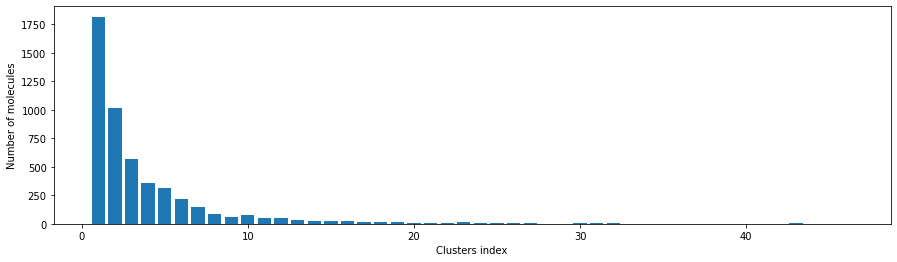

In [12]:
# Plot of the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Clusters index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);


- Como escolher um ponto de corte razoável?

- Como o resultado do agrupamento depende do limite escolhido, vamos testar cinco agrupamentos com cutoff diferentes.

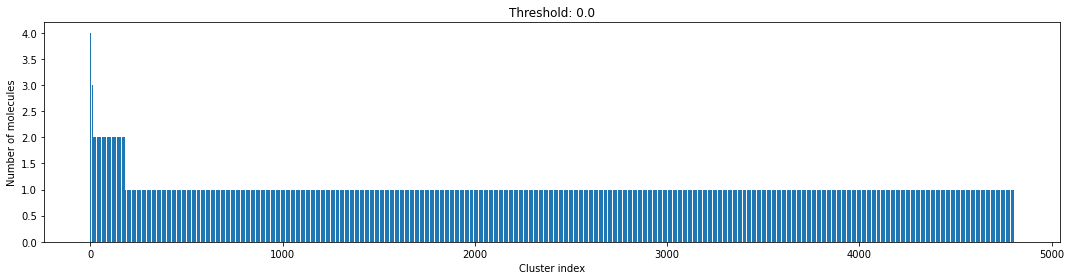

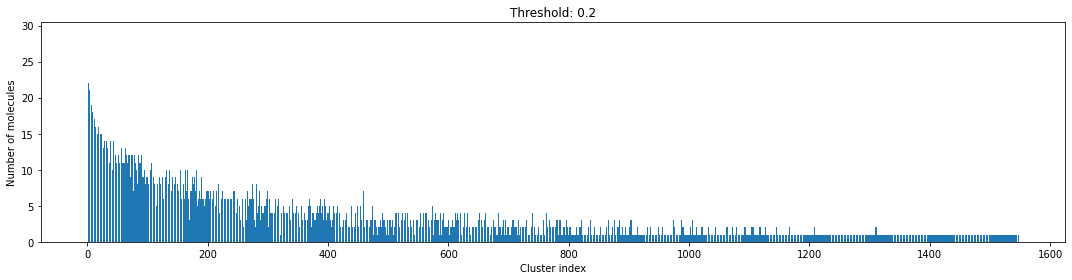

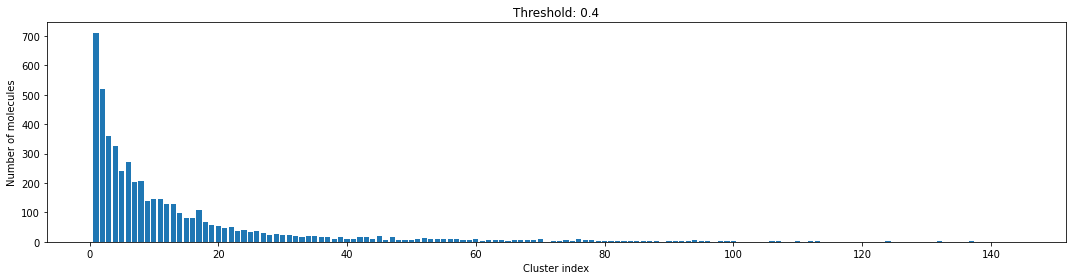

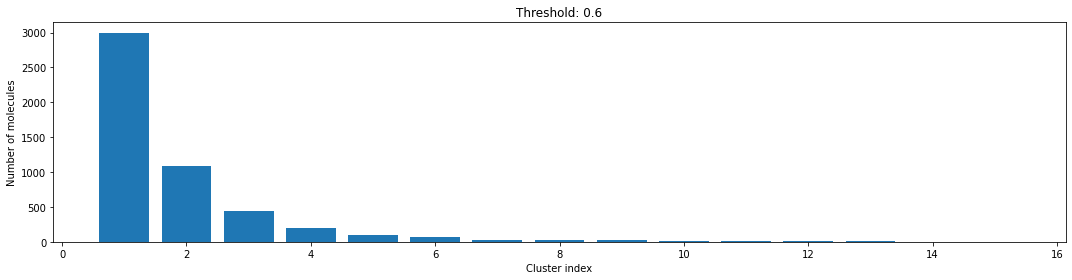

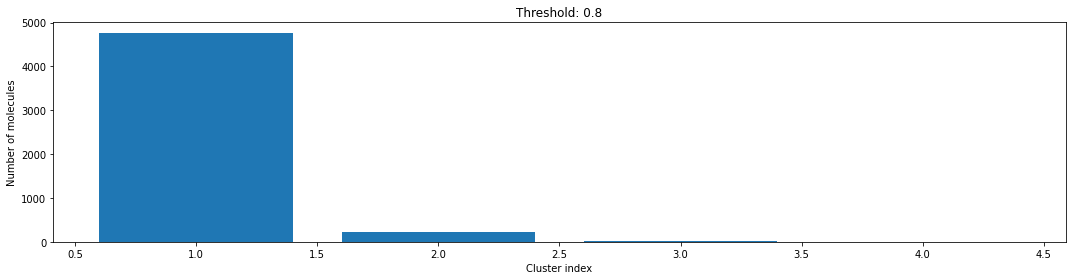

In [13]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    plt.tight_layout()

- Como se pode ver, quanto maior o ponto de corte, mais moléculas são consideradas semelhantes e, portanto, agrupadas em menos grupos. Quanto menor esse ponto, menores os clusters e “singletons” aparecem.

- *Quanto menor o cutoff, mais semelhantes os compostos devem ser para pertencer a um mesmo cluster.*

Number of clusters: 46 from 5000 molecules at distance cut-off 0.50
Number of molecules in largest cluster: 1816
Similarity between two random points in same cluster: 0.14
Similarity between two random points in different cluster: 0.70



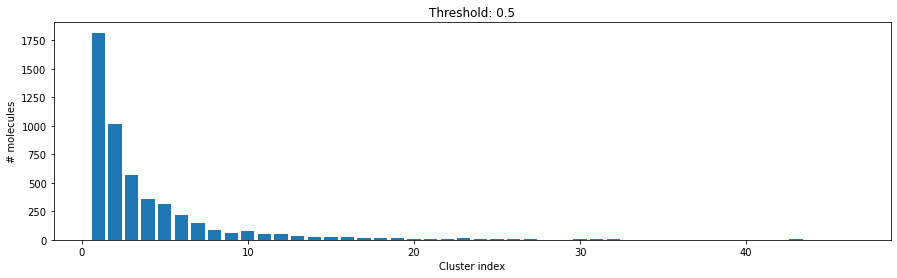

In [14]:
cutoff = 0.5
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")

fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(f"Number of clusters: {len(clusters)} from {len(fingerprints)} molecules at distance cut-off {cutoff:.2f}")
print("Number of molecules in largest cluster:", len(clusters[0]))
print(f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}")
print(f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}")
print("")

- Classificando os clusters por tamanho e as moléculas em cada cluster por similaridade.

In [15]:
# Define the fingerprint generator (still need to use 
# rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5) 
# to define the fingerprint generator, because 
# DataStructs.BulkTanimotoSimilarity expects RDKit fingerprints as input)
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [fingerprints[i] for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [16]:
print(sorted_clusters[-4:-1])

[(1, [4526]), (1, [4465]), (1, [4060])]


In [17]:
print(sorted_clusters[29])

(3, [4608, 3802, 4818])


# Análise dos tempos de execução

- No final podemos variar o tamanho do conjunto de dados e ver como o tempo de execução do clustering Butina muda.

In [18]:
# Helper function for time computation
def measure_runtime(size):
    start_time = time.time()
    sampled_data = sc.parallelize(np.random.randint(0, 2, size=(digits, size)), num_partitions)
    sampled_mols = np.array(sampled_data.collect())
    sampled_fingerprints = [DataStructs.cDataStructs.CreateFromBitString('0'*digits + ''.join(map(str, row))) for row in sampled_mols.T]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.5)
    return time.time() - start_time

In [19]:
sample_sizes = [100, 500, 1000, 2000, 4000]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(size)
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

Dataset size 100, time 0.17 seconds
Dataset size 500, time 0.60 seconds
Dataset size 1000, time 1.25 seconds
Dataset size 2000, time 6.29 seconds
Dataset size 4000, time 21.24 seconds


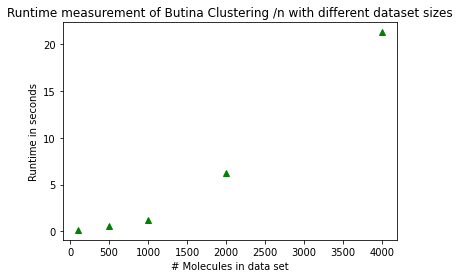

In [20]:
fig, ax = plt.subplots()
ax.set_title("Runtime measurement of Butina Clustering /n with different dataset sizes")
ax.set_xlabel("# Molecules in data set")
ax.set_ylabel("Runtime in seconds")
ax.plot(sample_sizes, runtimes, "g^");

- Observamos que o tempo de execução não é exatamente proporcional ao tamanho da amostra! Ele cresce mais rápido!